# Flight Delay Model

Modeling procedure to predict flight delays in the United States. Based on data from the Reporting Carrier On-Time Performance database from the US Bureau of Transportation Statistics. Utilizes neural network modeling from Tensorflow and Keras packages as well as GPU processing. A summary report of the findings can be found at https://github.com/Tate-G/portfolio

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
print(tf.config.list_physical_devices('GPU'))
print('Number of GPUs Available: ', len(tf.config.list_physical_devices('GPU')))
print('Tensorflow version: '+tf.version.VERSION)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs Available:  1
Tensorflow version: 2.1.0


## Input

Define input variables for this run of modeling and evaluation. User can train and evaluate a new set of models or load and evaluate a previously trained set of models.

In [3]:
#set whether to train new models (True) or load old models (False)
train_new_model=True
#set whether to calculate new feature importances (True) or load old feature importances (False)
find_feature_importances=True

#output file names
output_folder='4-8_Jan-Dec2019/'
metrics_output='metrics.csv'
feature_importance_output='model_feature_importances.csv'


#define the fist and last test month of the moving train-val-test windows
#will test on these months, validate on each previous month, and train on each 24 month period before validation
test_list_start='2019_1'
test_list_end='2019_12'


#define predictor variables
X_vars=['Month','DayOfWeek','Reporting_Airline',
            'Origin','Dest','OriginState','DestState',
            'CRSDepTime','CRSArrTime',
            'CRSElapsedTime'] #Distance highly correlated with elapsed time, use only one
X_vars_categorical=['Reporting_Airline','Origin','Dest','OriginState','DestState']
X_vars_hours=['CRSDepTime','CRSArrTime']
X_vars_cyclical_dict={'Month':12,'DayOfWeek':7,'CRSDepTime':24,'CRSArrTime':24}
X_vars_normalize=['CRSElapsedTime']
X_vars_log=['CRSElapsedTime'] #variables to log while normalizing, must be a subset of X_vars_normalize
y_var=['ArrDelayMinutes']

#define number of busiest airports to consider
num_airports=100

#define the delay length to consider
delay_minutes=15

#define the random fractions of train, validation, and test data to use
#true random subset if imbalanced==False, subset with increased % minority class (delays) if imbalanced==True
imbalanced=False
rand_frac_train=0.35
rand_frac_val=1
rand_frac_test=1

#define modeling parameters
Epochs = 15
Batch_Size = 2048



## Model Supporting Functions

Functions to support reading input data from csv files. Files stored in subfolder 'US_DOT/On-Time/'. Dataset csv files available for download at https://www.transtats.bts.gov/Tables.asp?DB_ID=120&DB_Name=Airline%20On-Time%20Performance%20Data&DB_Short_Name=On-Time 

In [4]:
#function to import csv files into dataframe
def read_flight_csv(filenames,col_names):
    df=pd.read_csv(filenames[0],usecols=col_names)
    print('Read '+filenames[0])
    if len(filenames)>1:
        for i in np.arange(1,len(filenames)):
            df=df.append(pd.read_csv(filenames[i],usecols=col_names))
            print('Read '+filenames[i])
    df=df.reset_index(drop=True)
    return df

#make list of filenames to import in a range of months starting from given YYYY_MM strings
def make_filenames(start_date,end_date):
    filename_start='US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_'
    filename_ext='.csv'
    start=datetime.strptime(start_date,'%Y_%m')
    end=datetime.strptime(end_date,'%Y_%m')
    dates=pd.date_range(start,end,freq='MS')
    date_list=dates.strftime('%Y_%#m').tolist()
    files=[filename_start+date+filename_ext for date in date_list]
    return files


#create moving windows of train-val-test file names
#Tests 1 month, validates on previous 1 month, trains on the 24 months before val
#Input first and last test month
#Returns list of training file lists, list of val files, list of training files
from dateutil.relativedelta import relativedelta
def moving_train_val_test_windows(test_list_start,test_list_end,training_months=24):
    
    test_list=make_filenames(test_list_start,test_list_end)
    test_list=[[file] for file in test_list]
    
    val_list_start=(datetime.strptime(test_list_start,'%Y_%m')-relativedelta(months=1)).strftime('%Y_%#m')
    val_list_end=(datetime.strptime(test_list_end,'%Y_%m')-relativedelta(months=1)).strftime('%Y_%#m')
    val_list=make_filenames(val_list_start,val_list_end)
    val_list=[[file] for file in val_list]

    train_list=['']*len(val_list)
    train_start_date=datetime.strptime(val_list_start,'%Y_%m')-relativedelta(months=training_months)
    train_end_date=datetime.strptime(val_list_start,'%Y_%m')-relativedelta(months=1)
    for i in np.arange(len(val_list)):
        train_list[i]=make_filenames(train_start_date.strftime('%Y_%#m'),train_end_date.strftime('%Y_%#m'))
        train_start_date=train_start_date+relativedelta(months=1)
        train_end_date=train_end_date+relativedelta(months=1)
    
    return train_list,val_list,test_list


Functions to support restricting data to only include flights to and from a given number of the busiest airports, and to clean airline names.

In [5]:
#function to find the given number of busiest airports in a dataset
def airport_select(df,num_airports):
    arrivals=df.groupby(['Dest']).size()
    departures=df.groupby(['Origin']).size()
    flights=arrivals+departures
    airports=flights.sort_values(ascending=False)[:num_airports].index.tolist()
    return airports
    
#function to restrict to list of airports
#this helps limit training data size and in most cases gives consistent lists of airports for train, val, and test
def airport_restrict(df,airports):
    restricted=df[(df['Dest'].isin(airports))&(df['Origin'].isin(airports))]
    return restricted


#function to give airlines actual names
#translates select airlines that have been integrated into other airlines over time
def airline_names(df):
    carriers=pd.read_csv('US_DOT/On-Time/L_UNIQUE_CARRIERS.csv')
    carrier_dict=pd.Series(carriers['Description'].values,index=carriers['Code']).to_dict()
    df_new=df.copy()
    df_new['Reporting_Airline']=df['Reporting_Airline'].map(carrier_dict)
    df_new.loc[df_new['Reporting_Airline']=='Virgin America','Reporting_Airline']='Alaska Airlines Inc.'  #Virgin America integrated into Alaska Airlines in 2018
    return df_new



Functions to extract and preprocess model features and target variable from data that has been read from 'On-Time' csv files. Supports feature cleaning, transformation, and normalization, as well as selection of a random subset of the dataset.

In [6]:

#function to encode cyclical time data into sin and cos variables
#usful resource at https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
def convert_cyclical(df,col_name_maxval_dict):
    df_copy=df.copy()
    for col in col_name_maxval_dict.keys():
        max_value=col_name_maxval_dict[col]
        df_copy['sin('+col+')']=np.sin(2*np.pi*df_copy[col]/max_value)
        df_copy['cos('+col+')']=np.cos(2*np.pi*df_copy[col]/max_value)
        df_copy.drop(col,axis=1,inplace=True)
    return df_copy

#function to convert times to decimal hours. 
#Format in file is an integer with hour in thousands and hundreds place and minutes in tens and ones place 
#(For example, in input csv 1415 corresponds to 2:15pm, convert to decimal hour 14.25)
def convert_hours(df,columns):
    df_copy=df.copy()
    for col in columns:
        df_copy[col]=df[col]//100+(df[col]%100)/60
    return df_copy


#function to produce the desired predictor and target variable dataframes
def predictors_and_target(df,X_vars,X_vars_categorical,target_delay_minutes=1):
    subset=df[X_vars]
    X=pd.get_dummies(subset,columns=X_vars_categorical)#one-hot encode the categorical variables
    y=df['ArrDelayMinutes']>=target_delay_minutes
    return X,y


#function to choose random subset of matching predictor and target rows
#if subset_frac is not less than 1, returns copies of original X and y
def rand_subset(X,y,subset_frac,rand_state=0):
    if subset_frac<1:
        X_copy=X.copy()
        X_copy['y']=y
        samp=X_copy.sample(frac=subset_frac,random_state=rand_state)
        y_samp=samp['y']
        X_samp=samp.drop(['y'],axis=1)
    else:
        X_samp=X.copy()
        y_samp=y.copy()
    return X_samp,y_samp


#function to choose imbalanced random subset of matching predictor and target rows
#if subset_frac is not less than 1, returns copies of original X and y
#if sum(y==True)>=len(y)*subset_frac//2, will return rows with equal number of T and F values in y
#if sum(y==True)<len(y)*subset_frac//2, include all rows where y is T and len(y)*subset_frac//2 rows where y is F
#same conditions on sum(y==False)
def imbalanced_subsample(X,y,subset_frac,rand_state=0):
    if subset_frac<1:
        X_copy=X.copy()
        X_copy['y']=y
        X_copy_T=X_copy[X_copy['y']==True]
        X_copy_F=X_copy[X_copy['y']==False]
        num_samp=X_copy.shape[0]*subset_frac
        if X_copy_T.shape[0]>=num_samp//2:
            samp_T=X_copy_T.sample(n=int(num_samp//2),random_state=rand_state)
        else:
            samp_T=X_copy_T
        if X_copy_F.shape[0]>=num_samp//2:
            samp_F=X_copy_F.sample(n=int(num_samp//2),random_state=rand_state)
        else:
            samp_F=X_copy_F
        samp=samp_T.append(samp_F)
        y_samp=samp['y']
        X_samp=samp.drop(['y'],axis=1)
    else:
        X_samp=X.copy()
        y_samp=y.copy()
    return X_samp,y_samp


#function to normalize continuous varaibles in train and test data
def normalize(X_train,X_val,X_test,X_vars_normalize,X_vars_log):
    from sklearn.preprocessing import StandardScaler
    scaler=StandardScaler()
    
    train_to_scale=X_train.loc[:,X_vars_normalize]
    val_to_scale=X_val.loc[:,X_vars_normalize]
    test_to_scale=X_test.loc[:,X_vars_normalize]
    train_to_log=train_to_scale.loc[:,X_vars_log]
    val_to_log=val_to_scale.loc[:,X_vars_log]
    test_to_log=test_to_scale.loc[:,X_vars_log]
    
    X_train_out=X_train.copy()
    X_val_out=X_val.copy()
    X_test_out=X_test.copy()
    
    train_to_scale[X_vars_log]=np.log(train_to_log)
    train_scaled=scaler.fit_transform(train_to_scale)
    X_train_out[X_vars_normalize]=train_scaled
    
    val_to_scale[X_vars_log]=np.log(val_to_log)
    val_scaled=scaler.transform(val_to_scale)
    X_val_out[X_vars_normalize]=val_scaled
    
    test_to_scale[X_vars_log]=np.log(test_to_log)
    test_scaled=scaler.transform(test_to_scale)
    X_test_out[X_vars_normalize]=test_scaled
    
    return X_train_out,X_val_out,X_test_out

#function to add categorical variables from train that are missing in validation or test
#(for example, an airport included in train that was not flown to in test)
#variables should be missing from val or test, not train
def missing_cat_add(X_train,X_val,X_test,X_vars_categorical):
    missing_in_val=np.setdiff1d(X_train.columns.tolist(),X_val.columns.tolist())
    X_val_new=X_val.assign(**dict.fromkeys([f for f in missing_in_val for x in X_vars_categorical if x in f],0))
    
    missing_in_test=np.setdiff1d(X_train.columns.tolist(),X_test.columns.tolist())
    X_test_new=X_test.assign(**dict.fromkeys([f for f in missing_in_test for x in X_vars_categorical if x in f],0))
    
    return X_val_new,X_test_new

Function to support full sequence of importing data: reading csv files, processing and subsamping data, and extracting predictive features and target variable. Note: after calling this for each of train, validation, and test data, normalization should be performed together since the same normalization (fitted to train) should be applied to all three.

In [7]:
#Read csv flight data, restrict airport list, convert hour and other cyclical data, and return predictor and target
#Must give either the number of airports (for train) or an airport list (for val and test)
def import_data(filenames,rand_frac,X_vars,X_vars_categorical,y_var,delay_minutes,
                X_vars_hours,X_vars_cyclical_dict,
                num_airports=None,airports_list=None,subsample_imbalanced=False):
    
    df=read_flight_csv(filenames,X_vars+y_var)
    df.dropna(inplace=True)  
    #EDA not shown here finds a few hundred CRSElapsedTime values missing some months, 
    #otherwise few tens of thousands of delay time targets missing out of half a million flights in a month
    if airports_list is not None:
        airports=airports_list
    else:
        airports=airport_select(df,num_airports)
    df_restricted=airline_names(airport_restrict(df,airports))
    
    X,y_full=predictors_and_target(df_restricted,X_vars,X_vars_categorical,delay_minutes)
    X_hours=convert_hours(X,X_vars_hours)
    X_full=convert_cyclical(X_hours,X_vars_cyclical_dict)
    
    if subsample_imbalanced:
        X_samp,y_samp=imbalanced_subsample(X_full,y_full,rand_frac)
    else:
        X_samp,y_samp=rand_subset(X_full,y_full,rand_frac)
    
    return X_samp,y_samp,airports,X_full,y_full


Define the Keras modeling procedure. Includes one dense layer and a dropout layer within a sequential model.

In [8]:
#create modeling procedure
#usful reference at https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

Metrics=[
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')]

def make_model(metrics=Metrics):
    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(X_train_normalized.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')])
    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    
    return model



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Function to evaluate model performance. Prints and returns model metrics and confusion matrix, and plots ROC curve and Precision-Recall curve. 

In [9]:
#function to evaluate performance of a single model
def evaluate_model(y_test,y_pred,y_prob,plot=True):
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    accuracy=accuracy_score(y_test, y_pred)
    precision=precision_score(y_test, y_pred)
    recall=recall_score(y_test, y_pred)
    
    from sklearn.metrics import roc_curve, auc
    fpr,tpr,_=roc_curve(y_test,y_prob[:,-1])
    roc_auc=auc(fpr,tpr)
    
    from sklearn.metrics import confusion_matrix
    confusion=confusion_matrix(y_test,y_pred)
    
    print('')
    print('Test Accuracy: {:.3f}'.format(accuracy))
    print('Test Precision: {:.3f}'.format(precision))
    print('Test Recall: {:.3f}'.format(recall))
    print('Test ROC Area Under Curve: {:.3f}'.format(roc_auc))
    print('Test confusion:')
    print(confusion)
    print('')
    
    if plot:
    
        f,ax=plt.subplots(1,2,figsize=(11,5))
    
        ax[0].plot(fpr,tpr)
        ax[0].plot([0, 1], [0, 1], color='black', linestyle='--')
        ax[0].set_xlim([0,1])
        ax[0].set_ylim([0,1])
        ax[0].axes.set_aspect('equal')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_title('ROC curve (area = {:.3f})'.format(roc_auc))

        from sklearn.metrics import precision_recall_curve
        precision_list, recall_list, thresholds = precision_recall_curve(y_test, y_prob[:,-1])
        ax[1].plot(precision_list, recall_list)
        ax[1].set_xlim([0,1])
        ax[1].set_ylim([0,1])
        ax[1].axes.set_aspect('equal')
        ax[1].set_xlabel('Precision')
        ax[1].set_ylabel('Recall')
    
        plt.show()
    
    return accuracy, precision, recall, roc_auc, confusion

## Model Training and Evaluation

Runs model training and evaluation, with one model produced for each specified test dataset. Prints loading, modeling, and evaluation progress to the terminal. Saves model weights and evaluation metrics. If train_new_model==False, loads existing model weights and metrics data.

******************************

Start model number 1

start data import 2021-04-08 21:19:41.414670
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2016_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_6.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_7.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_8.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_

Epoch 14/15
3726257/3726257 [==============================] - 46s 12us/sample - loss: 0.4656 - tp: 11634.0000 - fp: 11888.0000 - tn: 2998728.0000 - fn: 704007.0000 - accuracy: 0.8079 - precision: 0.4946 - recall: 0.0163 - auc: 0.6577 - val_loss: 0.4599 - val_tp: 9.0000 - val_fp: 5.0000 - val_tn: 399534.0000 - val_fn: 89902.0000 - val_accuracy: 0.8163 - val_precision: 0.6429 - val_recall: 1.0010e-04 - val_auc: 0.6384
Epoch 15/15
3726257/3726257 [==============================] - 46s 12us/sample - loss: 0.4655 - tp: 11853.0000 - fp: 12032.0000 - tn: 2998584.0000 - fn: 703788.0000 - accuracy: 0.8079 - precision: 0.4963 - recall: 0.0166 - auc: 0.6579 - val_loss: 0.4598 - val_tp: 11.0000 - val_fp: 3.0000 - val_tn: 399536.0000 - val_fn: 89900.0000 - val_accuracy: 0.8163 - val_precision: 0.7857 - val_recall: 1.2234e-04 - val_auc: 0.6388
model fitted 2021-04-08 21:35:05.075592
Model metrics:

Test Accuracy: 0.816
Test Precision: 0.742
Test Recall: 0.000
Test ROC Area Under Curve: 0.635
Test c

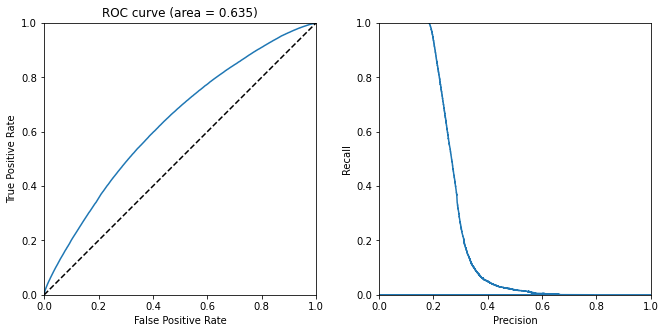

Model metrics with p=0.192:

Test Accuracy: 0.593
Test Precision: 0.251
Test Recall: 0.607
Test ROC Area Under Curve: 0.635
Test confusion:
[[226852 158001]
 [ 34144  52812]]

***

Stratified dummy classifier:

Test Accuracy: 0.695
Test Precision: 0.184
Test Recall: 0.191
Test ROC Area Under Curve: 0.500
Test confusion:
[[311096  73757]
 [ 70332  16624]]

******************************

******************************

******************************

Start model number 2

start data import 2021-04-08 21:35:42.741374
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_5.csv
Read US_DOT/On-Time

Epoch 13/15
3760323/3760323 [==============================] - 46s 12us/sample - loss: 0.4630 - tp: 16550.0000 - fp: 17380.0000 - tn: 3026643.0000 - fn: 699750.0000 - accuracy: 0.8093 - precision: 0.4878 - recall: 0.0231 - auc: 0.6586 - val_loss: 0.4604 - val_tp: 23.0000 - val_fp: 4.0000 - val_tn: 384849.0000 - val_fn: 86933.0000 - val_accuracy: 0.8157 - val_precision: 0.8519 - val_recall: 2.6450e-04 - val_auc: 0.6403
Epoch 14/15
3760323/3760323 [==============================] - 46s 12us/sample - loss: 0.4630 - tp: 16615.0000 - fp: 17186.0000 - tn: 3026837.0000 - fn: 699685.0000 - accuracy: 0.8094 - precision: 0.4916 - recall: 0.0232 - auc: 0.6588 - val_loss: 0.4601 - val_tp: 63.0000 - val_fp: 27.0000 - val_tn: 384826.0000 - val_fn: 86893.0000 - val_accuracy: 0.8158 - val_precision: 0.7000 - val_recall: 7.2450e-04 - val_auc: 0.6407
Epoch 15/15
3760323/3760323 [==============================] - 46s 12us/sample - loss: 0.4630 - tp: 16792.0000 - fp: 17471.0000 - tn: 3026552.0000 - fn: 69

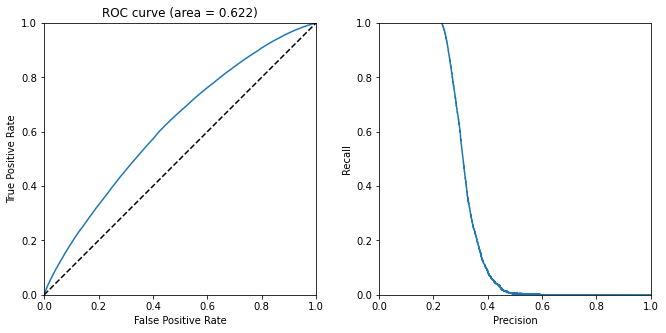

Model metrics with p=0.190:

Test Accuracy: 0.611
Test Precision: 0.305
Test Recall: 0.537
Test ROC Area Under Curve: 0.622
Test confusion:
[[209675 121595]
 [ 45939  53284]]

***

Stratified dummy classifier:

Test Accuracy: 0.667
Test Precision: 0.230
Test Recall: 0.190
Test ROC Area Under Curve: 0.501
Test confusion:
[[268168  63102]
 [ 80354  18869]]

******************************

******************************

******************************

Start model number 3

start data import 2021-04-08 21:49:44.523980
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_6.csv
Read US_DOT/On-Time

Epoch 13/15
3792026/3792026 [==============================] - 46s 12us/sample - loss: 0.4613 - tp: 12850.0000 - fp: 13631.0000 - tn: 3061390.0000 - fn: 704155.0000 - accuracy: 0.8107 - precision: 0.4853 - recall: 0.0179 - auc: 0.6587 - val_loss: 0.5333 - val_tp: 159.0000 - val_fp: 126.0000 - val_tn: 331144.0000 - val_fn: 99064.0000 - val_accuracy: 0.7696 - val_precision: 0.5579 - val_recall: 0.0016 - val_auc: 0.6209
Epoch 14/15
3792026/3792026 [==============================] - 46s 12us/sample - loss: 0.4612 - tp: 13349.0000 - fp: 13915.0000 - tn: 3061106.0000 - fn: 703656.0000 - accuracy: 0.8108 - precision: 0.4896 - recall: 0.0186 - auc: 0.6589 - val_loss: 0.5323 - val_tp: 167.0000 - val_fp: 129.0000 - val_tn: 331141.0000 - val_fn: 99056.0000 - val_accuracy: 0.7696 - val_precision: 0.5642 - val_recall: 0.0017 - val_auc: 0.6213
Epoch 15/15
3792026/3792026 [==============================] - 45s 12us/sample - loss: 0.4611 - tp: 13310.0000 - fp: 13734.0000 - tn: 3061287.0000 - fn: 70369

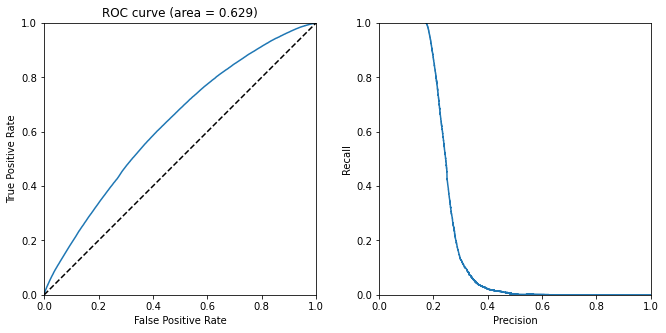

Model metrics with p=0.189:

Test Accuracy: 0.588
Test Precision: 0.233
Test Recall: 0.602
Test ROC Area Under Curve: 0.629
Test confusion:
[[248029 176239]
 [ 35418  53627]]

***

Stratified dummy classifier:

Test Accuracy: 0.704
Test Precision: 0.175
Test Recall: 0.190
Test ROC Area Under Curve: 0.500
Test confusion:
[[344437  79831]
 [ 72106  16939]]

******************************

******************************

******************************

Start model number 4

start data import 2021-04-08 22:03:52.439201
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_3.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_6.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_7.csv
Read US_DOT/On-Time

Epoch 13/15
3820856/3820856 [==============================] - 48s 13us/sample - loss: 0.4653 - tp: 12178.0000 - fp: 12059.0000 - tn: 3076687.0000 - fn: 719932.0000 - accuracy: 0.8084 - precision: 0.5025 - recall: 0.0166 - auc: 0.6564 - val_loss: 0.4468 - val_tp: 80.0000 - val_fp: 59.0000 - val_tn: 424209.0000 - val_fn: 88965.0000 - val_accuracy: 0.8266 - val_precision: 0.5755 - val_recall: 8.9842e-04 - val_auc: 0.6288
Epoch 14/15
3820856/3820856 [==============================] - 48s 13us/sample - loss: 0.4653 - tp: 12076.0000 - fp: 12084.0000 - tn: 3076662.0000 - fn: 720034.0000 - accuracy: 0.8084 - precision: 0.4998 - recall: 0.0165 - auc: 0.6564 - val_loss: 0.4471 - val_tp: 117.0000 - val_fp: 99.0000 - val_tn: 424169.0000 - val_fn: 88928.0000 - val_accuracy: 0.8266 - val_precision: 0.5417 - val_recall: 0.0013 - val_auc: 0.6275
Epoch 15/15
3820856/3820856 [==============================] - 48s 13us/sample - loss: 0.4652 - tp: 12492.0000 - fp: 12380.0000 - tn: 3076366.0000 - fn: 7196

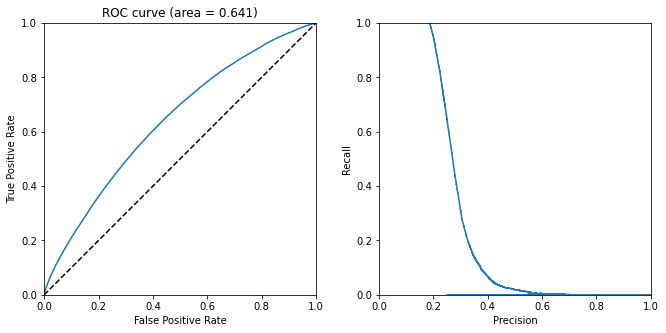

Model metrics with p=0.191:

Test Accuracy: 0.557
Test Precision: 0.246
Test Recall: 0.672
Test ROC Area Under Curve: 0.641
Test confusion:
[[214869 190152]
 [ 30266  62078]]

***

Stratified dummy classifier:

Test Accuracy: 0.695
Test Precision: 0.186
Test Recall: 0.191
Test ROC Area Under Curve: 0.502
Test confusion:
[[328036  76985]
 [ 74747  17597]]

******************************

******************************

******************************

Start model number 5

start data import 2021-04-08 22:18:38.668340
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_4.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_6.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_7.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_8.csv
Read US_DOT/On-Time

3855881/3855881 [==============================] - 47s 12us/sample - loss: 0.4639 - tp: 14327.0000 - fp: 14858.0000 - tn: 3106058.0000 - fn: 720638.0000 - accuracy: 0.8093 - precision: 0.4909 - recall: 0.0195 - auc: 0.6565 - val_loss: 0.4608 - val_tp: 352.0000 - val_fp: 219.0000 - val_tn: 404802.0000 - val_fn: 91992.0000 - val_accuracy: 0.8146 - val_precision: 0.6165 - val_recall: 0.0038 - val_auc: 0.6419
Epoch 13/15
3855881/3855881 [==============================] - 47s 12us/sample - loss: 0.4638 - tp: 14421.0000 - fp: 14765.0000 - tn: 3106151.0000 - fn: 720544.0000 - accuracy: 0.8093 - precision: 0.4941 - recall: 0.0196 - auc: 0.6567 - val_loss: 0.4608 - val_tp: 338.0000 - val_fp: 220.0000 - val_tn: 404801.0000 - val_fn: 92006.0000 - val_accuracy: 0.8146 - val_precision: 0.6057 - val_recall: 0.0037 - val_auc: 0.6426
Epoch 14/15
3855881/3855881 [==============================] - 47s 12us/sample - loss: 0.4638 - tp: 14300.0000 - fp: 14921.0000 - tn: 3105995.0000 - fn: 720665.0000 - acc

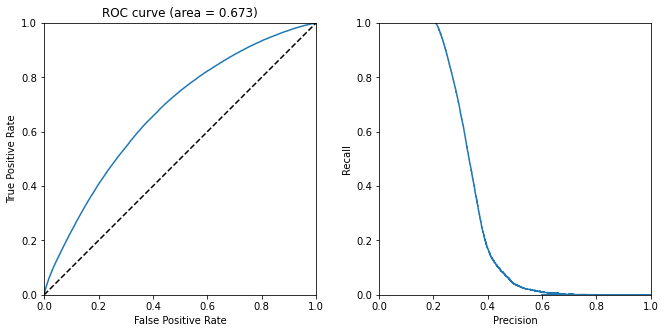

Model metrics with p=0.191:

Test Accuracy: 0.567
Test Precision: 0.288
Test Recall: 0.729
Test ROC Area Under Curve: 0.673
Test confusion:
[[214354 194290]
 [ 29203  78555]]

***

Stratified dummy classifier:

Test Accuracy: 0.681
Test Precision: 0.210
Test Recall: 0.192
Test ROC Area Under Curve: 0.501
Test confusion:
[[330954  77690]
 [ 87050  20708]]

******************************

******************************

******************************

Start model number 6

start data import 2021-04-08 22:33:18.075615
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_5.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_6.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_7.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_8.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_9.csv
Read US_DOT/On-Time

Epoch 13/15
3889222/3889222 [==============================] - 47s 12us/sample - loss: 0.4636 - tp: 10845.0000 - fp: 11433.0000 - tn: 3139093.0000 - fn: 727851.0000 - accuracy: 0.8099 - precision: 0.4868 - recall: 0.0147 - auc: 0.6547 - val_loss: 0.4826 - val_tp: 586.0000 - val_fp: 361.0000 - val_tn: 408281.0000 - val_fn: 107178.0000 - val_accuracy: 0.7918 - val_precision: 0.6188 - val_recall: 0.0054 - val_auc: 0.6728
Epoch 14/15
3889222/3889222 [==============================] - 47s 12us/sample - loss: 0.4637 - tp: 10594.0000 - fp: 11033.0000 - tn: 3139493.0000 - fn: 728102.0000 - accuracy: 0.8100 - precision: 0.4899 - recall: 0.0143 - auc: 0.6547 - val_loss: 0.4826 - val_tp: 466.0000 - val_fp: 270.0000 - val_tn: 408372.0000 - val_fn: 107298.0000 - val_accuracy: 0.7917 - val_precision: 0.6332 - val_recall: 0.0043 - val_auc: 0.6733
Epoch 15/15
3889222/3889222 [==============================] - 47s 12us/sample - loss: 0.4637 - tp: 10883.0000 - fp: 11066.0000 - tn: 3139460.0000 - fn: 727

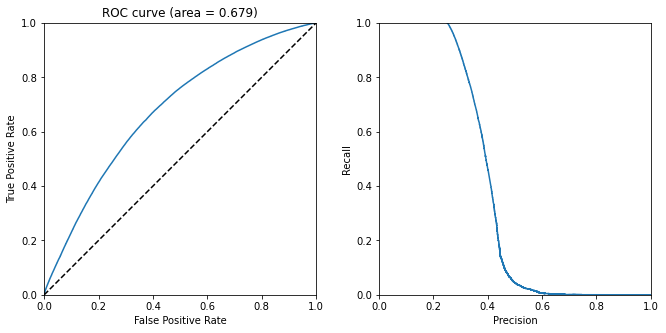

Model metrics with p=0.190:

Test Accuracy: 0.569
Test Precision: 0.339
Test Recall: 0.756
Test ROC Area Under Curve: 0.679
Test confusion:
[[193481 188827]
 [ 31256  96900]]

***

Stratified dummy classifier:

Test Accuracy: 0.655
Test Precision: 0.253
Test Recall: 0.192
Test ROC Area Under Curve: 0.500
Test confusion:
[[309615  72693]
 [103582  24574]]

******************************

******************************

******************************

Start model number 7

start data import 2021-04-08 22:47:48.792399
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_6.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_7.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_8.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_9.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_10.csv
Read US_DOT/On-Tim

Epoch 13/15
3923482/3923482 [==============================] - 48s 12us/sample - loss: 0.4641 - tp: 11573.0000 - fp: 12037.0000 - tn: 3164663.0000 - fn: 735209.0000 - accuracy: 0.8095 - precision: 0.4902 - recall: 0.0155 - auc: 0.6549 - val_loss: 0.5292 - val_tp: 1390.0000 - val_fp: 1006.0000 - val_tn: 381302.0000 - val_fn: 126766.0000 - val_accuracy: 0.7497 - val_precision: 0.5801 - val_recall: 0.0108 - val_auc: 0.6827
Epoch 14/15
3923482/3923482 [==============================] - 48s 12us/sample - loss: 0.4642 - tp: 11506.0000 - fp: 12101.0000 - tn: 3164599.0000 - fn: 735276.0000 - accuracy: 0.8095 - precision: 0.4874 - recall: 0.0154 - auc: 0.6547 - val_loss: 0.5285 - val_tp: 1430.0000 - val_fp: 1030.0000 - val_tn: 381278.0000 - val_fn: 126726.0000 - val_accuracy: 0.7497 - val_precision: 0.5813 - val_recall: 0.0112 - val_auc: 0.6823
Epoch 15/15
3923482/3923482 [==============================] - 47s 12us/sample - loss: 0.4641 - tp: 11348.0000 - fp: 11964.0000 - tn: 3164736.0000 - fn:

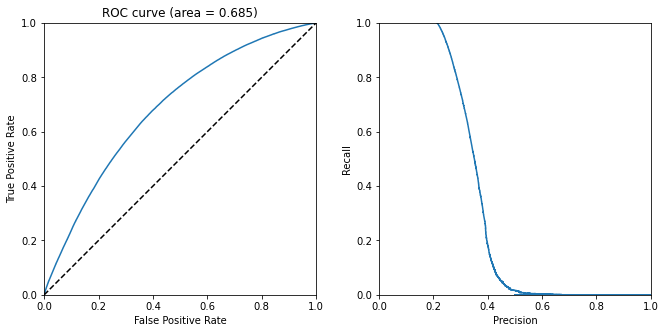

Model metrics with p=0.190:

Test Accuracy: 0.562
Test Precision: 0.296
Test Recall: 0.762
Test ROC Area Under Curve: 0.685
Test confusion:
[[210308 204147]
 [ 26772  85783]]

***

Stratified dummy classifier:

Test Accuracy: 0.678
Test Precision: 0.213
Test Recall: 0.190
Test ROC Area Under Curve: 0.500
Test confusion:
[[335725  78730]
 [ 91221  21334]]

******************************

******************************

******************************

Start model number 8

start data import 2021-04-08 23:03:09.436662
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_7.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_8.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_9.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_10.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_11.csv
Read US_DOT/On-Ti

Epoch 13/15
3954496/3954496 [==============================] - 48s 12us/sample - loss: 0.4657 - tp: 11141.0000 - fp: 12327.0000 - tn: 3184690.0000 - fn: 746338.0000 - accuracy: 0.8082 - precision: 0.4747 - recall: 0.0147 - auc: 0.6554 - val_loss: 0.4827 - val_tp: 1059.0000 - val_fp: 1008.0000 - val_tn: 413447.0000 - val_fn: 111496.0000 - val_accuracy: 0.7865 - val_precision: 0.5123 - val_recall: 0.0094 - val_auc: 0.6870
Epoch 14/15
3954496/3954496 [==============================] - 48s 12us/sample - loss: 0.4657 - tp: 11314.0000 - fp: 12240.0000 - tn: 3184777.0000 - fn: 746165.0000 - accuracy: 0.8082 - precision: 0.4803 - recall: 0.0149 - auc: 0.6553 - val_loss: 0.4820 - val_tp: 1291.0000 - val_fp: 1199.0000 - val_tn: 413256.0000 - val_fn: 111264.0000 - val_accuracy: 0.7866 - val_precision: 0.5185 - val_recall: 0.0115 - val_auc: 0.6888
Epoch 15/15
3954496/3954496 [==============================] - 48s 12us/sample - loss: 0.4657 - tp: 11585.0000 - fp: 12627.0000 - tn: 3184390.0000 - fn:

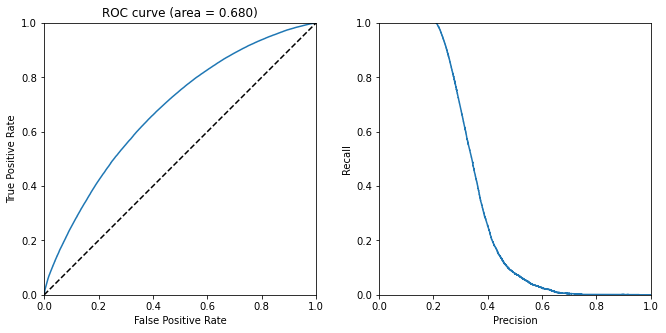

Model metrics with p=0.191:

Test Accuracy: 0.593
Test Precision: 0.298
Test Recall: 0.694
Test ROC Area Under Curve: 0.680
Test confusion:
[[237070 181564]
 [ 34093  77234]]

***

Stratified dummy classifier:

Test Accuracy: 0.679
Test Precision: 0.210
Test Recall: 0.192
Test ROC Area Under Curve: 0.501
Test confusion:
[[338321  80313]
 [ 89977  21350]]

******************************

******************************

******************************

Start model number 9

start data import 2021-04-08 23:18:10.686918
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_8.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_9.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_10.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_11.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_12.csv
Read US_DOT/On-T

3987707/3987707 [==============================] - 48s 12us/sample - loss: 0.4656 - tp: 10276.0000 - fp: 11464.0000 - tn: 3213556.0000 - fn: 752411.0000 - accuracy: 0.8084 - precision: 0.4727 - recall: 0.0135 - auc: 0.6548 - val_loss: 0.4804 - val_tp: 673.0000 - val_fp: 332.0000 - val_tn: 418302.0000 - val_fn: 110654.0000 - val_accuracy: 0.7906 - val_precision: 0.6697 - val_recall: 0.0060 - val_auc: 0.6809
Epoch 13/15
3987707/3987707 [==============================] - 48s 12us/sample - loss: 0.4656 - tp: 10365.0000 - fp: 11772.0000 - tn: 3213248.0000 - fn: 752322.0000 - accuracy: 0.8084 - precision: 0.4682 - recall: 0.0136 - auc: 0.6548 - val_loss: 0.4801 - val_tp: 674.0000 - val_fp: 369.0000 - val_tn: 418265.0000 - val_fn: 110653.0000 - val_accuracy: 0.7905 - val_precision: 0.6462 - val_recall: 0.0061 - val_auc: 0.6803
Epoch 14/15
3987707/3987707 [==============================] - 48s 12us/sample - loss: 0.4654 - tp: 10767.0000 - fp: 12123.0000 - tn: 3212897.0000 - fn: 751920.0000 - a

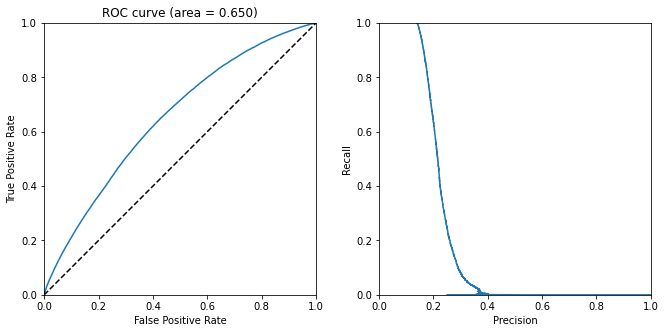

Model metrics with p=0.191:

Test Accuracy: 0.621
Test Precision: 0.206
Test Recall: 0.592
Test ROC Area Under Curve: 0.650
Test confusion:
[[264258 157949]
 [ 28166  40910]]

***

Stratified dummy classifier:

Test Accuracy: 0.721
Test Precision: 0.139
Test Recall: 0.190
Test ROC Area Under Curve: 0.501
Test confusion:
[[341056  81151]
 [ 55937  13139]]

******************************

******************************

******************************

Start model number 10

start data import 2021-04-08 23:33:22.749992
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_9.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_10.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_11.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_1.csv
Read US_DOT/On-

Epoch 13/15
4022548/4022548 [==============================] - 50s 12us/sample - loss: 0.4653 - tp: 12563.0000 - fp: 13687.0000 - tn: 3239190.0000 - fn: 757108.0000 - accuracy: 0.8084 - precision: 0.4786 - recall: 0.0163 - auc: 0.6557 - val_loss: 0.3930 - val_tp: 133.0000 - val_fp: 230.0000 - val_tn: 421977.0000 - val_fn: 68943.0000 - val_accuracy: 0.8592 - val_precision: 0.3664 - val_recall: 0.0019 - val_auc: 0.6531
Epoch 14/15
4022548/4022548 [==============================] - 50s 12us/sample - loss: 0.4652 - tp: 12768.0000 - fp: 13761.0000 - tn: 3239116.0000 - fn: 756903.0000 - accuracy: 0.8084 - precision: 0.4813 - recall: 0.0166 - auc: 0.6559 - val_loss: 0.3923 - val_tp: 127.0000 - val_fp: 200.0000 - val_tn: 422007.0000 - val_fn: 68949.0000 - val_accuracy: 0.8592 - val_precision: 0.3884 - val_recall: 0.0018 - val_auc: 0.6539
Epoch 15/15
4022548/4022548 [==============================] - 50s 12us/sample - loss: 0.4652 - tp: 12671.0000 - fp: 13658.0000 - tn: 3239219.0000 - fn: 75700

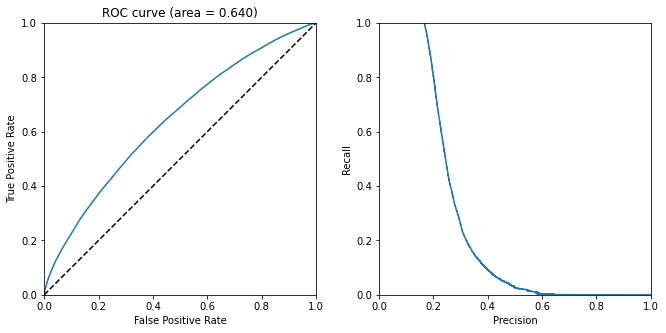

Model metrics with p=0.191:

Test Accuracy: 0.645
Test Precision: 0.240
Test Recall: 0.527
Test ROC Area Under Curve: 0.640
Test confusion:
[[291143 144153]
 [ 40893  45627]]

***

Stratified dummy classifier:

Test Accuracy: 0.706
Test Precision: 0.166
Test Recall: 0.192
Test ROC Area Under Curve: 0.501
Test confusion:
[[351801  83495]
 [ 69928  16592]]

******************************

******************************

******************************

Start model number 11

start data import 2021-04-08 23:49:03.670265
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_10.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_11.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_2.csv
Read US_DOT/On-

Epoch 13/15
4059648/4059648 [==============================] - 49s 12us/sample - loss: 0.4647 - tp: 13518.0000 - fp: 14740.0000 - tn: 3269222.0000 - fn: 762168.0000 - accuracy: 0.8086 - precision: 0.4784 - recall: 0.0174 - auc: 0.6561 - val_loss: 0.4314 - val_tp: 59.0000 - val_fp: 34.0000 - val_tn: 435262.0000 - val_fn: 86461.0000 - val_accuracy: 0.8342 - val_precision: 0.6344 - val_recall: 6.8192e-04 - val_auc: 0.6422
Epoch 14/15
4059648/4059648 [==============================] - 49s 12us/sample - loss: 0.4646 - tp: 13645.0000 - fp: 14827.0000 - tn: 3269135.0000 - fn: 762041.0000 - accuracy: 0.8086 - precision: 0.4792 - recall: 0.0176 - auc: 0.6565 - val_loss: 0.4313 - val_tp: 44.0000 - val_fp: 25.0000 - val_tn: 435271.0000 - val_fn: 86476.0000 - val_accuracy: 0.8342 - val_precision: 0.6377 - val_recall: 5.0855e-04 - val_auc: 0.6426
Epoch 15/15
4059648/4059648 [==============================] - 49s 12us/sample - loss: 0.4647 - tp: 13644.0000 - fp: 14683.0000 - tn: 3269279.0000 - fn: 7

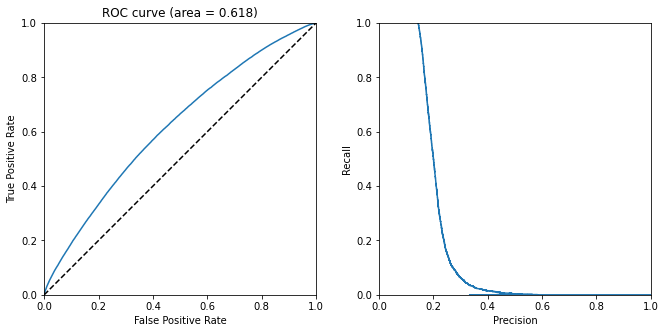

Model metrics with p=0.191:

Test Accuracy: 0.637
Test Precision: 0.199
Test Recall: 0.509
Test ROC Area Under Curve: 0.618
Test confusion:
[[278853 144909]
 [ 34768  36096]]

***

Stratified dummy classifier:

Test Accuracy: 0.721
Test Precision: 0.144
Test Recall: 0.192
Test ROC Area Under Curve: 0.500
Test confusion:
[[343103  80659]
 [ 57276  13588]]

******************************

******************************

******************************

Start model number 12

start data import 2021-04-09 00:04:31.119308
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_11.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2017_12.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_1.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_2.csv
Read US_DOT/On-Time/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_3.csv
Read US_DOT/On-T

Epoch 13/15
4089943/4089943 [==============================] - 50s 12us/sample - loss: 0.4656 - tp: 10496.0000 - fp: 11587.0000 - tn: 3296263.0000 - fn: 771597.0000 - accuracy: 0.8085 - precision: 0.4753 - recall: 0.0134 - auc: 0.6542 - val_loss: 0.4021 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 423129.0000 - val_fn: 70757.0000 - val_accuracy: 0.8567 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6188
Epoch 14/15
4089943/4089943 [==============================] - 51s 12us/sample - loss: 0.4655 - tp: 10911.0000 - fp: 11913.0000 - tn: 3295937.0000 - fn: 771182.0000 - accuracy: 0.8085 - precision: 0.4780 - recall: 0.0140 - auc: 0.6545 - val_loss: 0.4026 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 423129.0000 - val_fn: 70757.0000 - val_accuracy: 0.8567 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6196
Epoch 15/15
4089943/4089943 [==============================] - 50s 12us/sample - loss: 0.4655 - tp: 10702.0000 - fp: 11865.0000 - tn: 

C:\Users\gtate\Anaconda3\envs\tensorflow_environment\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test Accuracy: 0.793
Test Precision: 0.000
Test Recall: 0.000
Test ROC Area Under Curve: 0.634
Test confusion:
[[404130      0]
 [105357      0]]



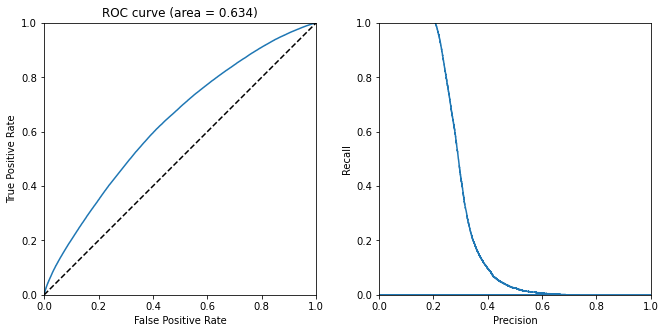

Model metrics with p=0.191:

Test Accuracy: 0.618
Test Precision: 0.285
Test Recall: 0.559
Test ROC Area Under Curve: 0.634
Test confusion:
[[255924 148206]
 [ 46424  58933]]

***

Stratified dummy classifier:

Test Accuracy: 0.680
Test Precision: 0.204
Test Recall: 0.189
Test ROC Area Under Curve: 0.499
Test confusion:
[[326518  77612]
 [ 85410  19947]]

******************************

******************************



In [10]:
train_file_list,val_file_list,test_file_list=moving_train_val_test_windows(test_list_start,test_list_end)

metrics=pd.DataFrame(index=np.arange(len(test_file_list)),
                     columns=['Test_data','Accuracy','Precision','Recall','ROC_AUC','Confusion'])
alt_metrics=pd.DataFrame(index=np.arange(len(test_file_list)),
                     columns=['Test_data','Accuracy','Precision','Recall','ROC_AUC','Confusion','Threshold'])
dummy_metrics=pd.DataFrame(index=np.arange(len(test_file_list)),
                           columns=['Test_data','Accuracy','Precision','Recall','ROC_AUC','Confusion'])


for i in np.arange(len(test_file_list)):
    #set train, val, and test files
    train_files=train_file_list[i]
    val_files=val_file_list[i]
    test_files=test_file_list[i]
    
    test_year_month=test_files[0].split('present)_')[1].split('.csv')[0]
    
    print('******************************\n')
    print('Start model number '+str(i+1))
    print('')
    
    ##############################
    #import and normalize data
    print('start data import '+str(datetime.now()))
    X_train,y_train,airports,X_train_full,y_train_full=import_data(train_files,rand_frac_train,
                                X_vars,X_vars_categorical,y_var,delay_minutes,
                                X_vars_hours,X_vars_cyclical_dict,
                                num_airports=num_airports,subsample_imbalanced=imbalanced)
    print('imported train '+str(datetime.now()))


    X_val,y_val,_,_,_=import_data(val_files,rand_frac_val,X_vars,X_vars_categorical,y_var,delay_minutes,
                                X_vars_hours,X_vars_cyclical_dict,airports_list=airports,subsample_imbalanced=imbalanced)
    print('imported validation '+str(datetime.now()))


    X_test,y_test,_,_,_=import_data(test_files,rand_frac_test,X_vars,X_vars_categorical,y_var,delay_minutes,
                                X_vars_hours,X_vars_cyclical_dict,airports_list=airports,subsample_imbalanced=imbalanced)
    print('imported test '+str(datetime.now()))


    X_train_normalized,X_val_norm0,X_test_norm0=normalize(X_train,X_val,X_test,X_vars_normalize,X_vars_log)
    X_val_normalized,X_test_normalized=missing_cat_add(X_train_normalized,X_val_norm0,X_test_norm0,X_vars_categorical)
    print('data normalized '+str(datetime.now()))
    

    ##############################
    #train model
    if train_new_model:
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc',verbose=1,patience=10,
                                                          mode='max',restore_best_weights=True)
        model=make_model()

        print('modeling begin '+str(datetime.now()))
        history=model.fit(X_train_normalized,y_train,batch_size=Batch_Size,epochs=Epochs,
                          validation_data=(X_val_normalized,y_val))
        model.save_weights(output_folder+test_year_month+'model')
        print('model fitted '+str(datetime.now()))
    else:
        model=make_model()
        model.load_weights(output_folder+test_year_month+'model')

    
    
    ##############################
    #Evaluate model performance
    print('Model metrics:')
    acc,prec,rec,auc,conf=evaluate_model(y_test,
                                         model.predict_classes(X_test_normalized),
                                         model.predict_proba(X_test_normalized))
    metrics.loc[i,'Test_data']=test_year_month
    metrics.loc[i,'Accuracy']=acc
    metrics.loc[i,'Precision']=prec
    metrics.loc[i,'Recall']=rec
    metrics.loc[i,'ROC_AUC']=auc
    metrics.loc[i,'Confusion']=conf
    
    #Evaluate model performance with adjusted proability threshold
    #Default behavior above tests against p=0.50, but by adjusting probability can adjust precision/recall balance
    alt_prob=np.mean(y_train_full) #percent of delays in the full training dataset
    print('Model metrics with p={:.3f}:'.format(alt_prob))
    alt_acc,alt_prec,alt_rec,alt_auc,alt_conf=evaluate_model(y_test,model.predict_proba(X_test_normalized)>alt_prob,
                             model.predict_proba(X_test_normalized),plot=False)
    alt_metrics.loc[i,'Test_data']=test_year_month
    alt_metrics.loc[i,'Accuracy']=alt_acc
    alt_metrics.loc[i,'Precision']=alt_prec
    alt_metrics.loc[i,'Recall']=alt_rec
    alt_metrics.loc[i,'ROC_AUC']=alt_auc
    alt_metrics.loc[i,'Confusion']=alt_conf
    alt_metrics.loc[i,'Threshold']=alt_prob
    
    #dummy model for comparison: randomly guess with proportion found in full training dataset
    from sklearn.dummy import DummyClassifier
    proportional_dummy=DummyClassifier(strategy='stratified').fit(X_train_full,y_train_full)
    print('***\n')
    print('Stratified dummy classifier:')
    strat_acc,strat_prec,strat_rec,strat_auc,strat_conf=evaluate_model(
        y_test,proportional_dummy.predict(X_test),proportional_dummy.predict_proba(X_test),plot=False)
    dummy_metrics.loc[i,'Test_data']=test_year_month
    dummy_metrics.loc[i,'Accuracy']=strat_acc
    dummy_metrics.loc[i,'Precision']=strat_prec
    dummy_metrics.loc[i,'Recall']=strat_rec
    dummy_metrics.loc[i,'ROC_AUC']=strat_auc
    dummy_metrics.loc[i,'Confusion']=strat_conf
    
    
    print('******************************\n')
    print('******************************\n')
    
if train_new_model:
    metrics.to_csv(output_folder+metrics_output)
    alt_metrics.to_csv(output_folder+'alt_'+metrics_output)
    dummy_metrics.to_csv(output_folder+'dummy_'+metrics_output)
else:
    metrics=pd.read_csv(output_folder+metrics_output)
    alt_metrics=pd.read_csv(output_folder+'alt_'+metrics_output)
    dummy_metrics=pd.read_csv(output_folder+'dummy_'+metrics_output)

Plot AUC for each model

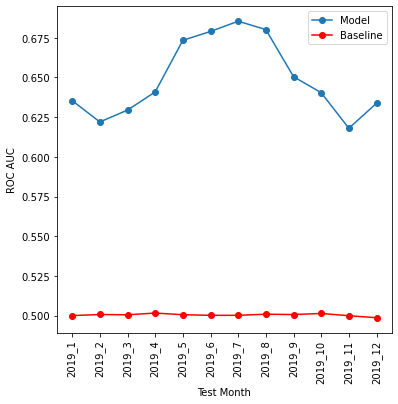

In [11]:
f,ax=plt.subplots(1,figsize=(6,6))
plt.plot(metrics['Test_data'],metrics['ROC_AUC'],'o-',label='Model')
plt.plot(dummy_metrics['Test_data'],dummy_metrics['ROC_AUC'],'ro-',label='Baseline')
plt.xticks(rotation='vertical')
ax.set_xlabel('Test Month')
ax.set_ylabel('ROC AUC')
ax.legend()
plt.show()

## Feature Importance

Functions to evaluate permutation feature importance for all features in a model. Error is defined as 1-AUC, and feature importance is defined as the ratio of the error with that feature randomly permuted to the error of the original data. Exact feature importance of any given feature will vary based on the random permutation, so feature importance is estimated by taking multiple random samples of the imput data, calculating feature importance for each, and returning the mean and standard deviation of the importance.

In [12]:
from sklearn.metrics import roc_curve, auc

#calculate error, defined as 1-AUC
def error(X,y,model):
    eval_results=model.evaluate(X,y,batch_size=Batch_Size, verbose=0)
    roc_auc=eval_results[model.metrics_names.index('auc')]
    error=1-roc_auc
    return error

#estimate permutation feature importance for each feature: (error with feature randomized)/(original error)
#returns dataframe with mean and stdev feature importance for each feature
def perm_feature_importance_samples(X,y,model,samples=10,sample_size=500000):
    error_original=error(X,y,model)
    df=pd.DataFrame(data={'Feature':X_train_normalized.columns.tolist()})
    
    for i in df.index.tolist():
        feature=df.loc[i,'Feature']
        FI=np.zeros(samples)
        for j in np.arange(samples):
            samp=X.sample(n=sample_size)
            samp[feature]=np.random.permutation(samp[feature].values.tolist())
            error_new=error(samp,y[samp.index.tolist()],model)
            FI[j]=error_new/error_original
        if (i+1)%25==0:
            print('calculated importance of feature number '+str(i+1)+' of '+str(len(df.index.tolist()))+' at '+str(datetime.now()))
        df.loc[i,'Mean_Importance']=np.mean(FI)
        df.loc[i,'Stdev_Importance']=np.std(FI)
    
    return df


The below calculates feature importances for each feature in the model. (If find_feature_importances==False, loads previously calculated values.) Note that feature importances will vary from model to model. The last model trained and tested above is used here.

One might consider whether to find feature importances using the training or test data. On training data feature importance shows which features the model relies upon to make predictions, whereas on test data feature importance shows how well the feature helps generate accurate new predictions (see for example the discussion at https://christophm.github.io/interpretable-ml-book/feature-importance.html). Here I choose to calculate feature importance using the training data for key practical reasons: Month is constant for each individual test dataset, so any feature importance calculated on test data will not evaluate the Month variable or include variability other features may have from month to month.

When calculating feature importances with hundreds of features (as here), there is a potential multiple comparisons problem: some features will seem to have significant feature importance just by random chance. Feature importance greater than 1.00 even beyond +/- 2 standard deviations should not be treated as statistically significant as you may if you were only testing one feature. On the other hand, feature importance as calculated here likely does not capture the entire effect of a feature in the model: only one variable is examined at time, so important interactions between variables are not considered. On balance, feature importances given here are useful for highlighting the approximate relative effect each feature has on a model. In this application, these values may for example be useful toward identifying airlines, airports, etc. where process improvements may have the largest impact toward reducing flight delays.

In [13]:
if find_feature_importances:

    print('start feature importance '+str(datetime.now()))

    train_feature_imps=perm_feature_importance_samples(X_train_normalized,y_train,model)

    train_sorted_feat_imps=train_feature_imps.sort_values(by='Mean_Importance',ascending=False)

    feats=train_sorted_feat_imps['Feature'].values.tolist()
    imps=train_sorted_feat_imps['Mean_Importance'].values.tolist()
    stdevs=train_sorted_feat_imps['Stdev_Importance'].values.tolist()
    for feat,imp,stdev in zip(feats,imps,stdevs):
        print(feat+': {:.4f} +/- {:.4f}'.format(imp,stdev))
    
    print('end feature importance '+str(datetime.now()))
    
    train_sorted_feat_imps.to_csv(output_folder+test_year_month+feature_importance_output)
else:
    train_sorted_feat_imps=pd.read_csv(output_folder+test_year_month+feature_importance_output)

start feature importance 2021-04-09 00:20:28.105065
calculated importance of feature number 25 of 310 at 2021-04-09 00:32:21.254857
calculated importance of feature number 50 of 310 at 2021-04-09 00:43:55.892162
calculated importance of feature number 75 of 310 at 2021-04-09 00:55:29.978232
calculated importance of feature number 100 of 310 at 2021-04-09 01:07:03.601447
calculated importance of feature number 125 of 310 at 2021-04-09 01:18:37.919745
calculated importance of feature number 150 of 310 at 2021-04-09 01:30:11.282011
calculated importance of feature number 175 of 310 at 2021-04-09 01:41:45.805113
calculated importance of feature number 200 of 310 at 2021-04-09 01:53:19.275417
calculated importance of feature number 225 of 310 at 2021-04-09 02:04:52.578297
calculated importance of feature number 250 of 310 at 2021-04-09 02:16:26.042030
calculated importance of feature number 275 of 310 at 2021-04-09 02:28:03.055617
calculated importance of feature number 300 of 310 at 2021-0

Functions supporting various plot types showing top feature importances and showing relationships between delay probability and individual features.

In [14]:
#function to plot top feature importances
def top_FI_plot(sorted_feat_imps,num_features,stdev_error=2):
    top_features=sorted_feat_imps[:num_features].sort_values(by='Mean_Importance',ascending=True)
    FI=top_features['Mean_Importance']
    names=[x.split('Airline_')[-1] for x in top_features['Feature']]
    error=[x*stdev_error for x in top_features['Stdev_Importance']]

    f,ax=plt.subplots(1,figsize=(5,10))
    plt.errorbar(x=FI,y=names,xerr=error,fmt='o')
    plt.grid(axis='x')
    ax.xaxis.tick_top()
    ax.set_xlabel('Feature Importance ('+str(stdev_error)+r'$\sigma$ error)')
    ax.xaxis.set_label_position('top')
    plt.show()
    return


#function to print percent of delay probabilities above overall median for each top categorical feature
def top_categorical_distribs(sorted_feat_imps,num_features,X_data):
    top_features=sorted_feat_imps[:num_features]
    top_cat_features=list(dict.fromkeys([f for f in top_features['Feature'] for x in X_vars_categorical if x in f]))
    median_prob=np.median(model.predict_proba(X_data))
    print('Median delay probability in data: {:.1f}%'.format(100*median_prob))
    print('Percent of flights above median delay probability:')
    for feat in top_cat_features:
        print(feat.split('Airline_')[-1]+': {:.1f}%'.format(
            100*np.mean(model.predict_proba(X_data[X_data[feat]==True])>median_prob)))
    return


#function to plot probability histograms for categorical features
def categorical_histograms(feature_list,X_data,plot_whole=True,bins=np.linspace(0,1,20)):
    f,ax=plt.subplots(1,figsize=(6,6))
    
    if plot_whole:
        all_probs=[x[0] for x in model.predict_proba(X_data)]
        plt.hist(all_probs,alpha=1,density=True,bins=bins,color='k',histtype='step',label='All Flights')
    
    probs=[0]*len(feature_list)
    labels=[0]*len(feature_list)
    for i,f in enumerate(feature_list):
        probs[i]=[x[0] for x in model.predict_proba(X_data[X_data[f]==True])]
        labels[i]=f.split('Airline_')[-1]
    
    plt.hist(probs,alpha=0.3,density=True,bins=bins,histtype='stepfilled',label=labels)
    ax.set_xlabel('Delay Probability')
    ax.set_ylabel('Probability Density')
    ax.set_yticklabels([])
    ax.legend()
    plt.show()
    return


#function to find delay probabilities over a discrete cyclical variable (months, days of week)
def cyclical_prob(column,var_max,X_data,label=None,x_label_list=None):
    cyclical_probs=pd.DataFrame(columns=['mean','stdev'])
    for i in np.arange(1,var_max+1):
        probs=model.predict_proba(X_data[(X_data['cos('+column+')']==np.cos(2*np.pi*i/var_max)) 
                                         & (X_data['sin('+column+')']==np.sin(2*np.pi*i/var_max))])
        cyclical_probs.loc[i,'mean']=np.mean(probs)
        cyclical_probs.loc[i,'stdev']=np.std(probs)

    f,ax=plt.subplots(1,figsize=(6,4))
    plt.errorbar(x=cyclical_probs.index.to_list(),y=cyclical_probs['mean'],yerr=cyclical_probs['stdev'],fmt='o')
    if label is None:
        label=column
    ax.set_xlabel(label)
    ax.set_ylabel(r'Delay Probability (+/-1$\sigma$)')
    if x_label_list is not None:
        plt.xticks(cyclical_probs.index.to_list(),x_label_list,rotation='vertical')
    plt.show()
    return

#function to find actual delay occurrence over a discrete cyclical variable (months, days of week)
def cyclical_actual(column,var_max,X_data,y_data,label=None,x_label_list=None):
    cyclical_actual=pd.DataFrame(columns=['mean'])
    for i in np.arange(1,var_max+1):
        actual=y_data[(X_data['cos('+column+')']==np.cos(2*np.pi*i/var_max)) 
                     & (X_data['sin('+column+')']==np.sin(2*np.pi*i/var_max))]
        cyclical_actual.loc[i,'mean']=np.mean(actual)

    f,ax=plt.subplots(1,figsize=(6,4))
    plt.plot(cyclical_actual.index.to_list(),cyclical_actual['mean'],'ko-')
    if label is None:
        label=column
    ax.set_xlabel(label)
    ax.set_ylabel('Actual Delay Fraction')
    if x_label_list is not None:
        plt.xticks(cyclical_actual.index.to_list(),x_label_list,rotation='vertical')
    plt.show()
    return

#function to find delay probabilities over continuous cyclical variable (departure and arrival time of day)
def time_prob(column,var_max,X_data,label=None):
    cyclical_probs=pd.DataFrame(columns=['mean','stdev'])
    for i in np.arange(0,var_max):
        cos_data=X_data['cos('+column+')']
        sin_data=X_data['sin('+column+')']
        cos_test=np.cos(2*np.pi*i/var_max)
        cos_test_ip1=np.cos(2*np.pi*(i+1)/var_max)
        sin_test=np.sin(2*np.pi*i/var_max)
        sin_test_ip1=np.sin(2*np.pi*(i+1)/var_max)
        probs=model.predict_proba(X_data[(((cos_data>=cos_test)&(cos_data<cos_test_ip1))|
                                          ((cos_data<=cos_test)&(cos_data>cos_test_ip1)))&
                                         (((sin_data>=sin_test)&(sin_data<sin_test_ip1))|
                                          ((sin_data<=sin_test)&(sin_data>sin_test_ip1)))])
        cyclical_probs.loc[i,'mean']=np.mean(probs)
        cyclical_probs.loc[i,'stdev']=np.std(probs)

    f,ax=plt.subplots(1,figsize=(6,4))
    plt.errorbar(x=cyclical_probs.index.to_list(),y=cyclical_probs['mean'],yerr=cyclical_probs['stdev'],fmt='o')
    if label is None:
        label=column
    ax.set_xlabel(label)
    ax.set_ylabel(r'Delay Probability (+/-1$\sigma$)')
    plt.show()
    
    return

#function to find actual delay occurrence over continuous cyclical variable (departure and arrival time of day)
def time_actual(column,var_max,X_data,y_data,label=None):
    cyclical_actual=pd.DataFrame(columns=['mean','count'])
    for i in np.arange(0,var_max):
        cos_data=X_data['cos('+column+')']
        sin_data=X_data['sin('+column+')']
        cos_test=np.cos(2*np.pi*i/var_max)
        cos_test_ip1=np.cos(2*np.pi*(i+1)/var_max)
        sin_test=np.sin(2*np.pi*i/var_max)
        sin_test_ip1=np.sin(2*np.pi*(i+1)/var_max)
        actual=y_data[(((cos_data>=cos_test)&(cos_data<cos_test_ip1))|
                                          ((cos_data<=cos_test)&(cos_data>cos_test_ip1)))&
                                         (((sin_data>=sin_test)&(sin_data<sin_test_ip1))|
                                          ((sin_data<=sin_test)&(sin_data>sin_test_ip1)))]
        cyclical_actual.loc[i,'mean']=np.mean(actual)
        cyclical_actual.loc[i,'count']=len(actual)
        

    f,ax=plt.subplots(1,figsize=(6,4))
    plt.plot(cyclical_actual.index.to_list(),cyclical_actual['mean'],'ko-')
    if label is None:
        label=column
    ax.set_xlabel(label)
    ax.set_ylabel('Actual Delay Fraction')
    plt.show()
    f,ax=plt.subplots(1,figsize=(6,4))
    plt.plot(cyclical_actual.index.to_list(),cyclical_actual['count'],'ko-')
    ax.set_xlabel(label)
    ax.set_ylabel('Actual Flight Count')
    plt.show()
    
    return


#function to plot delay probabilities over a continuous non-cyclical variable (like elapsed time)
def continuous_prob(column,n_bins,X_data,label=None):
    cont_probs=pd.DataFrame(columns=['mean','stdev','pct_HI'])
    spacing=np.max(X_data[column])/n_bins
    for i in np.arange(n_bins):
        X_subset=X_data[(X_data[column]>=i*spacing)&(X_data[column]<(i+1)*spacing)]
        probs=model.predict_proba(X_subset)
        cont_probs.loc[i,'mean']=np.mean(probs)
        cont_probs.loc[i,'stdev']=np.std(probs)
        cont_probs.loc[i,'pct_HI']=np.mean(X_subset['OriginState_HI']+X_subset['DestState_HI'])

    f,ax=plt.subplots(1,figsize=(6,4))
    plt.errorbar(x=cont_probs.index.to_list(),y=cont_probs['mean'],yerr=cont_probs['stdev'],fmt='o')
    if label is None:
        label=column
    ax.set_xlabel(label)
    ax.set_ylabel(r'Delay Probability (+/-1$\sigma$)')
    plt.show()
    f,ax=plt.subplots(1,figsize=(6,4))
    plt.plot(cont_probs.index.to_list(),cont_probs['pct_HI'],'o-')
    ax.set_xlabel(label)
    ax.set_ylabel('Fraction of flights to+from HI')
    plt.show()
    
    return

#function to plot actual delay occurrence over a continuous non-cyclical variable (like elapsed time)
def continuous_actual(column,n_bins,X_data,y_data,label=None):
    cont_actual=pd.DataFrame(columns=['mean','count','pct_HI'])
    spacing=np.max(X_data[column])/n_bins
    for i in np.arange(n_bins):
        X_subset=X_data[(X_data[column]>=i*spacing)&(X_data[column]<(i+1)*spacing)]
        actual=y_data[(X_data[column]>=i*spacing)&(X_data[column]<(i+1)*spacing)]
        cont_actual.loc[i*spacing,'mean']=np.mean(actual)
        cont_actual.loc[i*spacing,'count']=len(actual)
        cont_actual.loc[i*spacing,'pct_HI']=np.mean(X_subset['OriginState_HI']+X_subset['DestState_HI'])

    f,ax=plt.subplots(1,figsize=(6,4))
    plt.plot(cont_actual.index.to_list(),cont_actual['mean'],'ko-')
    if label is None:
        label=column
    ax.set_xlabel(label)
    ax.set_ylabel('Actual Delay Percent')
    plt.show()
    f,ax=plt.subplots(1,figsize=(6,4))
    plt.plot(cont_actual.index.to_list(),cont_actual['pct_HI'],'ko-')
    ax.set_xlabel(label)
    ax.set_ylabel('Actual Fraction of flights to+from HI')
    plt.show()
    f,ax=plt.subplots(1,figsize=(6,4))
    plt.plot(cont_actual.index.to_list(),cont_actual['count'],'ko-')
    ax.set_xlabel(label)
    ax.set_ylabel('Actual Flight Count')
    plt.show()
    
    return

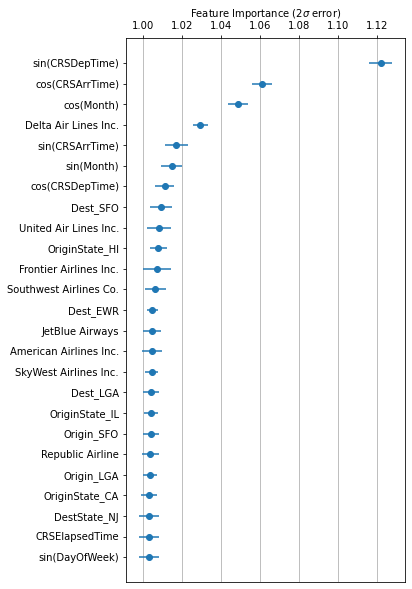

In [15]:
#Make plot of feature importances
top_FI_plot(train_sorted_feat_imps,25)

In [16]:
#print information on the probability distributions of the top categorical features
top_categorical_distribs(train_sorted_feat_imps,25,X_train_normalized)

Median delay probability in data: 18.6%
Percent of flights above median delay probability:
Delta Air Lines Inc.: 23.7%
Dest_SFO: 84.3%
United Air Lines Inc.: 53.5%
OriginState_HI: 13.0%
Frontier Airlines Inc.: 93.2%
Southwest Airlines Co.: 48.2%
Dest_EWR: 70.8%
JetBlue Airways: 69.6%
American Airlines Inc.: 57.1%
SkyWest Airlines Inc.: 54.1%
Dest_LGA: 70.6%
OriginState_IL: 77.7%
Origin_SFO: 72.6%
Republic Airline: 47.6%
Origin_LGA: 63.7%
OriginState_CA: 46.5%
DestState_NJ: 70.8%


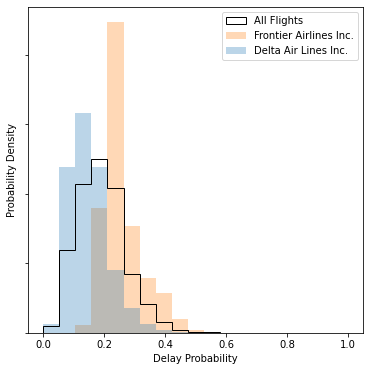

In [17]:
#plot delay probability distributions for select airlines
feature_list=['Reporting_Airline_Delta Air Lines Inc.','Reporting_Airline_Frontier Airlines Inc.']
categorical_histograms(feature_list,X_train_normalized)


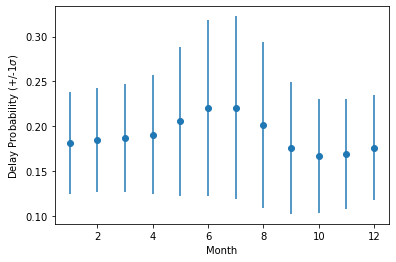

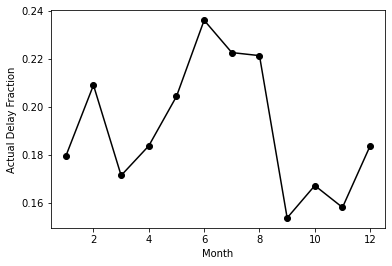

In [18]:
#plot delay probability and actual delay occurrence by month

cyclical_prob('Month',12,X_train_normalized)

cyclical_actual('Month',12,X_train_full,y_train_full)




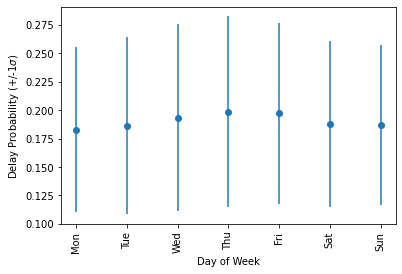

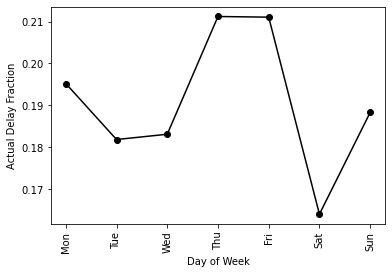

In [19]:
#plot delay probability and actual delay occurrence by day of the week

day_labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

cyclical_prob('DayOfWeek',7,X_train_normalized,'Day of Week',x_label_list=day_labels)

cyclical_actual('DayOfWeek',7,X_train_full,y_train_full,'Day of Week',x_label_list=day_labels)

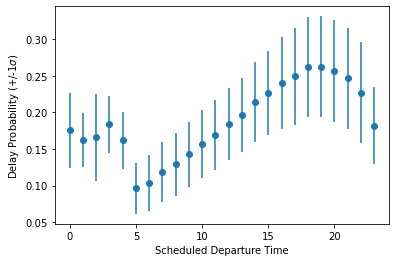

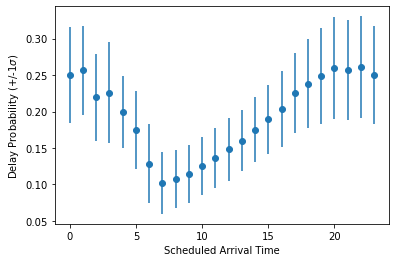

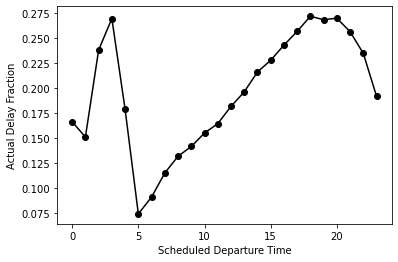

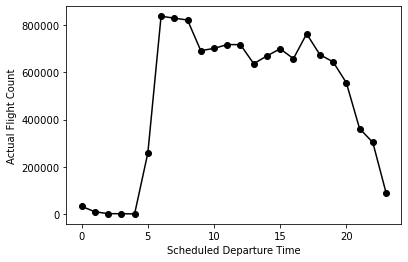

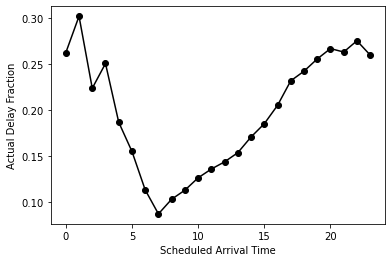

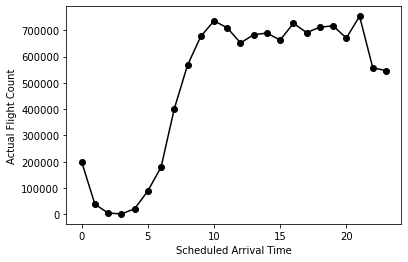

In [20]:
#plot delay probability and actual delay occurrence by time of day

time_prob('CRSDepTime',24,X_train_normalized,'Scheduled Departure Time')
time_prob('CRSArrTime',24,X_train_normalized,'Scheduled Arrival Time')

time_actual('CRSDepTime',24,X_train_full,y_train_full,'Scheduled Departure Time')
time_actual('CRSArrTime',24,X_train_full,y_train_full,'Scheduled Arrival Time')


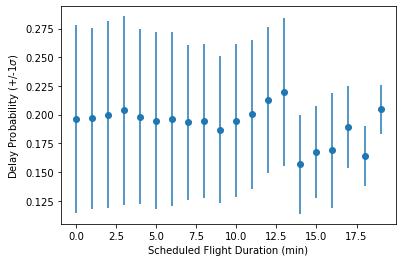

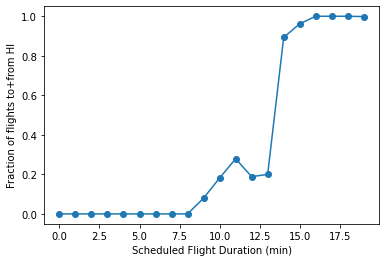

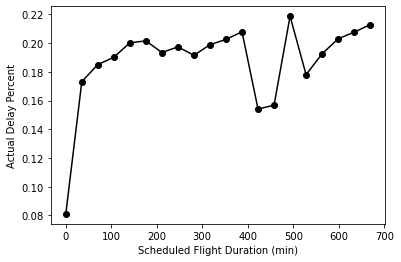

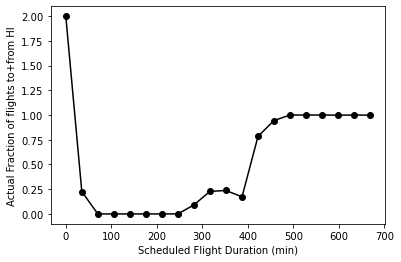

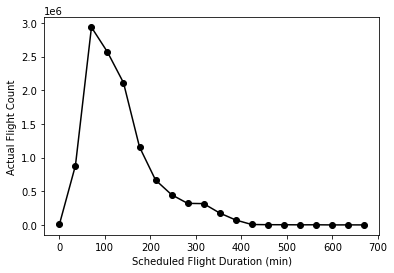

In [21]:
#plot delay probability and actual delay occurrence by scheduled flight duration

continuous_prob('CRSElapsedTime',20,X_train_normalized,'Scheduled Flight Duration (min)')
#note this has been logged AND passed through standard scaler, not straightforward to get it back to original elapsed times
#sudden drop is when switch to group of almost all flights to/from HI, with have low delay probability

continuous_actual('CRSElapsedTime',20,X_train_full,y_train_full,'Scheduled Flight Duration (min)')
#after restricting to the 100 busiest airports, all of the shortest flights are to AND from HI, so fraction>1

## Resources

Useful tensorflow resources: <br>
https://www.tensorflow.org/tutorials/structured_data/feature_columns, <br>
https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers, <br>
https://www.tensorflow.org/tutorials/structured_data/time_series,  <br>
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data <br>

Cyclical time discussion: https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning

Permutation feature importance discussion: https://christophm.github.io/interpretable-ml-book/feature-importance.html